https://medium.com/analytics-vidhya/building-a-text-classification-model-using-bilstm-c0548ace26f2

In [ ]:
import pandas as pd
url = '/Users/patsnap/Desktop/Neo4J_and_other_codes/OLIDv1/olid-training-v1.0.tsv'
df = pd.read_csv(url, sep="\t")
df.head()

In [3]:
del df['subtask_b']
del df['subtask_c']
del df['id']
df.columns = ['tweet', 'label']
df.head()

,tweet,label
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT


In [6]:
!pip install contractions
!pip install inflect

     |████████████████████████████████| 312 kB 8.7 MB/s eta 0:00:01
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp37-cp37m-macosx_10_7_x86_64.whl size=31865 sha256=53c1587f2d6aa7f38a670b131c3029b497f5f955986f1e5716e29a380655a536
  Stored in directory: /Users/patsnap/Library/Caches/pip/wheels/9b/6b/f7/62dc8caf183b125107209c014e78c340a0b4b7b392c23c2db4
Successfully built pyahocorasick


In [7]:
#importing required libraries
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
# First function is used to denoise text
def denoise_text(text):
    # Strip html if any. For ex. removing <html>, <p> tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    # Replace contractions in the text. For ex. didn't -> did not
    text = contractions.fix(text)
    return text
# Check the function 
sample_text = "<p>he didn't say anything </br> about what's gonna <html> happen in the climax"
denoise_text(sample_text)

'he did not say anything  about what is going to  happen in the climax'

In [9]:
# Text normalization includes many steps.
# Each function below serves a step.
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [10]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [ ]:
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

In [17]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [18]:
# Testing the functions
print("remove_non_ascii results: ", remove_non_ascii(['h', 'ॐ', '©', '1']))
print("to_lowercase results: ", to_lowercase(['HELLO', 'hiDDen', 'wanT', 'GOING']))
print("remove_punctuation results: ", remove_punctuation(['hello!!', 'how?', 'done,']))
print("replace_numbers results: ", replace_numbers(['1', '2', '3']))
print("remove_stopwords results: ", remove_stopwords(['this', 'and', 'amazing']))
print("stem_words results: ", stem_words(['beautiful', 'flying', 'waited']))
print("lemmatize_verbs results: ", lemmatize_verbs(['hidden', 'walking', 'ran']))
print("normalize_text results: ", normalize_text(['hidden', 'in', 'the', 'CAVES', 'he', 'WAited', '2', 'ॐ', 'hours!!']))

remove_non_ascii results:  ['h', '', '', '1']
to_lowercase results:  ['hello', 'hidden', 'want', 'going']
remove_punctuation results:  ['hello', 'how', 'done']
replace_numbers results:  ['one', 'two', 'three']
remove_stopwords results:  ['amazing']
stem_words results:  ['beauty', 'fly', 'wait']
lemmatize_verbs results:  ['hide', 'walk', 'run']
normalize_text results:  ['hide', 'cav', 'wait', 'two', 'hour']


In [19]:
# Tokenize tweet into words
def tokenize(text):
    return nltk.word_tokenize(text)
# check the function
sample_text = 'he did not say anything  about what is going to  happen'
print("tokenize results :", tokenize(sample_text))

tokenize results : ['he', 'did', 'not', 'say', 'anything', 'about', 'what', 'is', 'going', 'to', 'happen']


In [20]:
def text_prepare(text):
    text = denoise_text(text)
    text = ' '.join([x for x in normalize_text(tokenize(text))])
    return text
df['tweet'] = [text_prepare(x) for x in df['tweet']]
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,tweet,label
0,us ask nat be tak,1
1,us us go hom drink us mag trump2020 url,1
2,amazon investig chin employ sel intern dat thi...,0
3,us someon shouldvetak piec shit volcano,1
4,us us obam want lib illeg mov red stat,0


In [30]:
from tensorflow.keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential
from tensorflow.keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-06-10 17:22:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-06-10 17:22:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-06-10 17:22:26--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [24]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [25]:
def prepare_model_input(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    # pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    # Uncomment above line to save the tokenizer as .pkl file 
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]
    embeddings_dict = {}
    f = open("glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)
## Check function
x_train_sample = ["Lorem Ipsum is simply dummy text of the printing and typesetting industry", "It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout"]
x_test_sample = ["I’m creating a macro and need some text for testing purposes", "I’m designing a document and don’t want to get bogged down in what the text actually says"]
X_train_Glove_s, X_test_Glove_s, word_index_s, embeddings_dict_s = prepare_model_input(x_train_sample, x_test_sample, 100, 20)
print("\n X_train_Glove_s \n ", X_train_Glove_s)
print("\n X_test_Glove_s \n ", X_test_Glove_s)
print("\n Word index of the word testing is : ", word_index_s["testing"])
print("\n Embedding for thw word want \n \n", embeddings_dict_s["want"])

Found 51 unique tokens.
(4, 20)
Total 400000 word vectors.

 X_train_Glove_s 
  [[ 0  0  0  0  0  0  0  0  8  9  5 10 11  2  6  3 12  4 13 14]
 [17 18 19  1 20 21 22 23 24  3 25 26  6  1 27 28 29 30 31 32]]

 X_test_Glove_s 
  [[ 0  0  0  0  0  0  0  0  0  7 33  1 34  4 35 36  2 37 38 39]
 [ 0  0  0  7 40  1 41  4 42 43 44 45 46 47 48 49  3  2 50 51]]

 Word index of the word testing is :  38

 Embedding for thw word want 
 
 [ 0.13627  -0.054478  0.3703   -0.41574   0.60568  -0.42729  -0.50151
  0.35923  -0.49154   0.21827  -0.15193   0.52536  -0.24206   0.023875
  0.8225    1.089     0.98825  -0.17803   0.77806  -1.0647   -0.28742
  0.50458   0.21612   0.65681   0.34295  -2.1084   -0.82557  -0.31966
  0.87567  -1.0679    3.3802    1.2084   -1.272    -0.15921  -0.25237
 -0.2696   -0.18756  -0.35523   0.084172 -0.56539  -0.24081   0.15926
  0.3287    0.54591   0.29897   0.18948  -0.57113   0.17399  -0.19338
  0.51921 ]


In [26]:
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequebtial model
    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))
    # Add the fully connected layer with 256 nurons and relu activation
    model.add(Dense(256, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [31]:
X = df.tweet
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train,X_test)
print("Done!")
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Preparing model input ...
Found 12353 unique tokens.
(13240, 500)
Total 400000 word vectors.
Done!
Building Model!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 50)           617700    
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 64)           21248     
_________________________________________________________________
dropout (Dropout)            (None, 500, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 64)           24832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 64)           24832     
_____

In [32]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }
def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [33]:
history = model.fit(X_train_Glove, y_train,
                           validation_data=(X_test_Glove,y_test),
                           epochs=5,
                           batch_size=128,
                           verbose=1)

Epoch 1/5
83/83 [==============================] - 305s 4s/step - loss: 0.6200 - accuracy: 0.6695 - val_loss: 0.5666 - val_accuracy: 0.7179
Epoch 2/5
83/83 [==============================] - 383s 5s/step - loss: 0.5529 - accuracy: 0.7286 - val_loss: 0.5335 - val_accuracy: 0.7443
Epoch 3/5
83/83 [==============================] - 425s 5s/step - loss: 0.4986 - accuracy: 0.7688 - val_loss: 0.5182 - val_accuracy: 0.7530
Epoch 4/5
83/83 [==============================] - 376s 5s/step - loss: 0.4365 - accuracy: 0.8096 - val_loss: 0.5583 - val_accuracy: 0.7375
Epoch 5/5
83/83 [==============================] - 317s 4s/step - loss: 0.3773 - accuracy: 0.8431 - val_loss: 0.6071 - val_accuracy: 0.7130


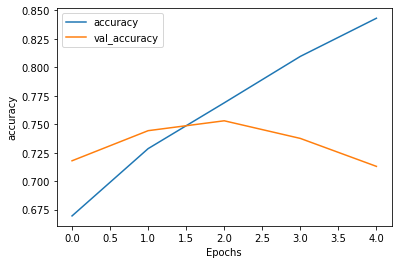

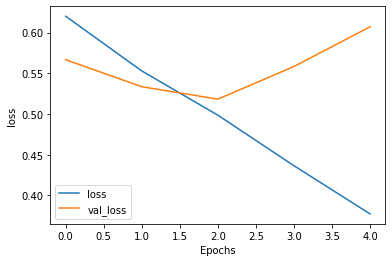

In [34]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [35]:
print("\n Evaluating Model ... \n")
predicted = model.predict_classes(X_test_Glove)
print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
INFO:logger:  mcc = 0.39668873141045247
INFO:logger:  true positive = 606
INFO:logger:  true negative = 1282
INFO:logger:  false positive = 490
INFO:logger:  false negative = 270
INFO:logger:  pricision = 0.5529197080291971
INFO:logger:  recall = 0.6917808219178082
INFO:logger:  F1 = 0.6146044624746451
INFO:logger:  accuracy = 0.7129909365558912


              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1772
           1       0.55      0.69      0.61       876

    accuracy                           0.71      2648
   macro avg       0.69      0.71      0.69      2648
weighted avg       0.74      0.71      0.72      2648



